In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import datetime as dt
import keras
from keras import models
from keras import layers
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

population = 33942526
gamma = 1/12

In [2]:
def SIR(data,date,rep_num):
    new_date = date + dt.timedelta(1)
    
    new_cases = gamma * rep_num * data['cases_active']
    new_recovered = gamma * data['cases_active']
    
    susceptible = data['susceptible'] - new_cases
    active_cases = data['cases_active'] + new_cases - new_recovered
    recovered = data['cases_recovered_C']
    
    return new_date,new_cases,active_cases,new_recovered,recovered,susceptible,rep_num

def get_data():
    df = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv',
                          parse_dates = ['date'],index_col = ['date'])
    
    new_df = df.loc[:,['cases_new','cases_active']]
    
    new_df['cases_recovered'] = (new_df['cases_active'].shift() + new_df['cases_new']) - new_df['cases_active']
    new_df['cases_recovered_C'] = new_df['cases_recovered'].cumsum()
    new_df['susceptible'] = population - new_df['cases_active'] - new_df['cases_recovered_C']
    growth_rate = (new_df['cases_active'] - new_df['cases_active'].shift()) / new_df['cases_active'].shift()
    new_df['reproduction_number'] = np.maximum(0,1 + (growth_rate / gamma))
    #a = new_df['reproduction_number'] - 1
    #new_df['cases_active_calc'] = new_df['cases_active'].shift() + (gamma * a * new_df['cases_active'].shift())
    new_df.to_csv('malaysia-covid-cases.csv')
    
    return new_df.loc[new_df.index < '2022-11-01']

def set_sequence(size,data):
    x = []
    y = []
    
    for count in range(len(data) - size):
        window = [[s] for s in data[count : count + size]]
        label = data[count + size]
        
        x.append(window)
        y.append(label)
        
    return np.array(x),np.array(y)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [3]:
df = get_data()

df

,cases_new,cases_active,cases_recovered,cases_recovered_C,susceptible,reproduction_number
date,,,,,,
2020-01-25,4,4,NaN,NaN,NaN,NaN
2020-01-26,0,4,0.0,0.0,33942522.0,1.000000
2020-01-27,0,4,0.0,0.0,33942522.0,1.000000
2020-01-28,0,4,0.0,0.0,33942522.0,1.000000
2020-01-29,3,7,0.0,0.0,33942519.0,10.000000
...,...,...,...,...,...,...
2022-10-27,2762,28720,1275.0,4861717.0,29052089.0,1.655234
2022-10-28,3296,30055,1961.0,4863678.0,29048793.0,1.557799
2022-10-29,3189,30702,2542.0,4866220.0,29045604.0,1.258326


**TRAINING MODEL**

In [4]:
TRAIN_SPLIT = int(0.8 * len(df.index))

train = df.loc[(df.index > df.index[0]) & (df.index < df.index[TRAIN_SPLIT]),'reproduction_number'].tolist()
test = df.loc[df.index >= df.index[TRAIN_SPLIT],'reproduction_number'].tolist()

Model Sequence Length 5

In [5]:
tf.random.set_seed(1)
np.random.seed(1)

x_train_5,y_train_5 = set_sequence(5,train)
x_test_5,y_test_5 = set_sequence(5,test)

input_shape = x_train_5.shape[1:]

model_5 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_5.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model_5.fit(
    x_train_5,
    y_train_5,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model_5.evaluate(x_test_5, y_test_5, verbose=1)

Epoch 1/200
11/11 [==============================] - 8s 255ms/step - loss: 7.6461 - val_loss: 2.4261
Epoch 2/200
11/11 [==============================] - 2s 182ms/step - loss: 6.5725 - val_loss: 2.1075
Epoch 3/200
11/11 [==============================] - 2s 187ms/step - loss: 7.0201 - val_loss: 1.8498
Epoch 4/200
11/11 [==============================] - 2s 140ms/step - loss: 6.4069 - val_loss: 1.6739
Epoch 5/200
11/11 [==============================] - 2s 169ms/step - loss: 5.7755 - val_loss: 1.5576
Epoch 6/200
11/11 [==============================] - 2s 151ms/step - loss: 5.5904 - val_loss: 1.4865
Epoch 7/200
11/11 [==============================] - 2s 186ms/step - loss: 5.1848 - val_loss: 1.4427
Epoch 8/200
11/11 [==============================] - 2s 176ms/step - loss: 5.6556 - val_loss: 1.4097
Epoch 9/200
11/11 [==============================] - 2s 164ms/step - loss: 4.9815 - val_loss: 1.3793
Epoch 10/200
11/11 [==============================] - 2s 166ms/step - loss: 4.9778 - val_lo

11/11 [==============================] - 2s 210ms/step - loss: 2.0631 - val_loss: 0.0693
Epoch 82/200
11/11 [==============================] - 2s 154ms/step - loss: 2.0527 - val_loss: 0.0692
Epoch 83/200
11/11 [==============================] - 2s 198ms/step - loss: 2.0443 - val_loss: 0.0717
Epoch 84/200
11/11 [==============================] - 2s 187ms/step - loss: 2.0177 - val_loss: 0.0736
Epoch 85/200
11/11 [==============================] - 2s 162ms/step - loss: 2.1039 - val_loss: 0.0756
Epoch 86/200
11/11 [==============================] - 2s 141ms/step - loss: 2.0235 - val_loss: 0.0720
Epoch 87/200
11/11 [==============================] - 2s 199ms/step - loss: 1.8805 - val_loss: 0.0690
Epoch 88/200
11/11 [==============================] - 2s 227ms/step - loss: 1.8156 - val_loss: 0.0704
Epoch 89/200
11/11 [==============================] - 2s 150ms/step - loss: 1.8933 - val_loss: 0.0700
Epoch 90/200
11/11 [==============================] - 2s 183ms/step - loss: 1.9402 - val_loss: 

0.12049438804388046

7/7 [==============================] - 1s 9ms/step
Score (RMSE): 0.3471230236062755


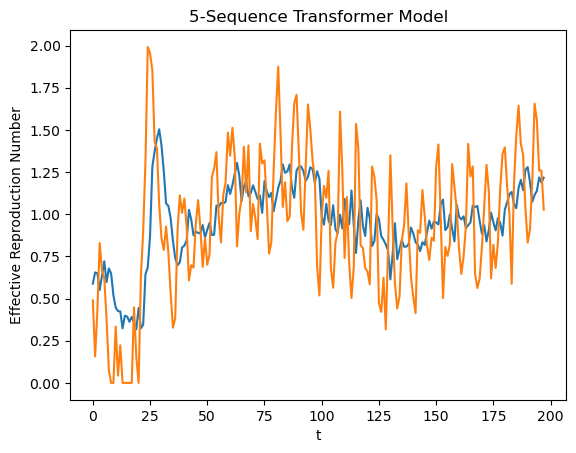

In [6]:
pred_5 = model_5.predict(x_test_5)
score = np.sqrt(metrics.mean_squared_error(pred_5,y_test_5))
print("Score (RMSE): {}".format(score))

plt.figure()
plt.plot(range(len(pred_5)),pred_5)
plt.plot(range(len(y_test_5)),y_test_5)
plt.title('5-Sequence Transformer Model')
plt.ylabel('Effective Reproduction Number')
plt.xlabel('t')
plt.show()

In [7]:
sub_df_5 = df.loc[df.index >= df.index[TRAIN_SPLIT + 5],['reproduction_number']]

sub_df_5.loc[sub_df_5.index >= df.index[TRAIN_SPLIT + 5],'reproduction_number'] = [pred_5[i][0] for i in range(len(pred_5))]
sub_df_5['prediction'] = 0
sub_df_5['actual'] = df.loc[df.index >= df.index[TRAIN_SPLIT + 5],'cases_new']
sub_df_5['error'] = 0

sub_df_5.head(10)

,reproduction_number,prediction,actual,error
date,,,,
2022-04-17,0.588534,0,6623,0
2022-04-18,0.655097,0,7140,0
2022-04-19,0.649354,0,6069,0
2022-04-20,0.550568,0,6968,0
2022-04-21,0.635528,0,5899,0
2022-04-22,0.721166,0,6342,0
2022-04-23,0.597233,0,5624,0
2022-04-24,0.678372,0,4006,0
2022-04-25,0.648828,0,2478,0


In [8]:
for idx in sub_df_5.index:
    rep_num = sub_df_5.loc[idx,'reproduction_number']
    sub_df_5.loc[idx,'prediction'] = SIR(df.loc[idx - dt.timedelta(1)],idx - dt.timedelta(1),rep_num)[1]
    sub_df_5.loc[idx,'error'] = sub_df_5.loc[idx,'prediction'] - sub_df_5.loc[idx,'actual']

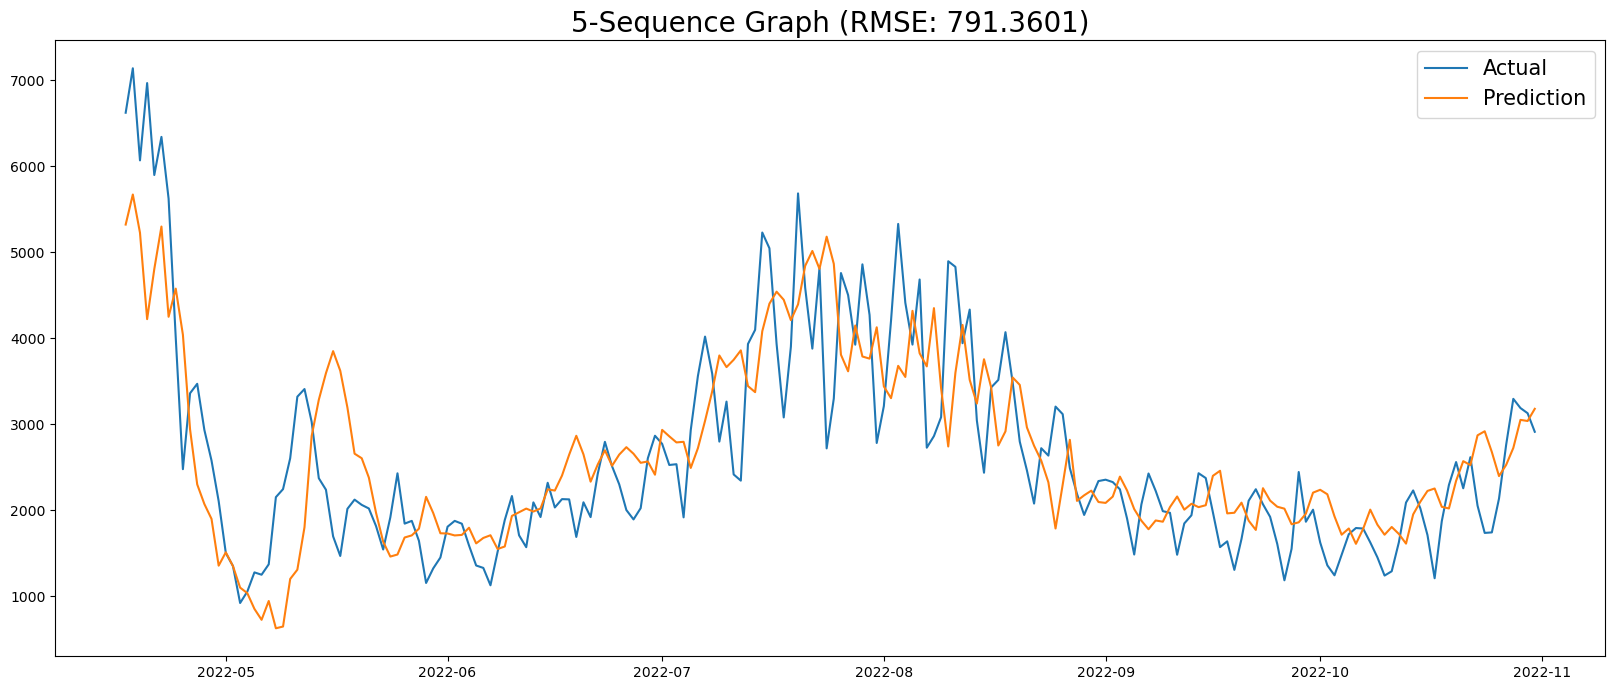

In [9]:
error_5 = np.sqrt((sub_df_5['error'] ** 2).mean())

plt.figure(figsize=(20,8))
plt.plot(df.loc[df.index >= df.index[TRAIN_SPLIT + 5],'cases_new'])
plt.plot(sub_df_5['prediction'])
plt.title(f'5-Sequence Graph (RMSE: {np.round(error_5,4)})',fontsize=20)
plt.legend(['Actual','Prediction'],fontsize=15)
plt.show()

In [10]:
sub_df_5

,reproduction_number,prediction,actual,error
date,,,,
2022-04-17,0.588534,5322.506913,6623,-1300.493087
2022-04-18,0.655097,5672.158474,7140,-1467.841526
2022-04-19,0.649354,5227.458047,6069,-841.541953
2022-04-20,0.550568,4222.903694,6968,-2745.096306
2022-04-21,0.635528,4804.910557,5899,-1094.089443
...,...,...,...,...
2022-10-27,1.113969,2528.059743,2762,-233.940257
2022-10-28,1.138596,2725.039899,3296,-570.960101
2022-10-29,1.218416,3051.623450,3189,-137.376550


Model Sequence Length 7

In [11]:
tf.random.set_seed(1)
np.random.seed(1)

x_train_7,y_train_7 = set_sequence(7,train)
x_test_7,y_test_7 = set_sequence(7,test)

input_shape = x_train_7.shape[1:]

model_7 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_7.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model_7.fit(
    x_train_7,
    y_train_7,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model_7.evaluate(x_test_7, y_test_7, verbose=1)

Epoch 1/200
10/10 [==============================] - 6s 281ms/step - loss: 7.3823 - val_loss: 2.0392
Epoch 2/200
10/10 [==============================] - 1s 151ms/step - loss: 6.1371 - val_loss: 1.7921
Epoch 3/200
10/10 [==============================] - 2s 151ms/step - loss: 6.0725 - val_loss: 1.6139
Epoch 4/200
10/10 [==============================] - 2s 193ms/step - loss: 4.7638 - val_loss: 1.4914
Epoch 5/200
10/10 [==============================] - 2s 217ms/step - loss: 5.5181 - val_loss: 1.4019
Epoch 6/200
10/10 [==============================] - 2s 169ms/step - loss: 4.9948 - val_loss: 1.3396
Epoch 7/200
10/10 [==============================] - 2s 163ms/step - loss: 4.7539 - val_loss: 1.2790
Epoch 8/200
10/10 [==============================] - 1s 130ms/step - loss: 5.2791 - val_loss: 1.2171
Epoch 9/200
10/10 [==============================] - 1s 143ms/step - loss: 4.3813 - val_loss: 1.1416
Epoch 10/200
10/10 [==============================] - 1s 153ms/step - loss: 4.0135 - val_lo

10/10 [==============================] - 2s 212ms/step - loss: 2.1537 - val_loss: 0.0526
Epoch 82/200
10/10 [==============================] - 2s 174ms/step - loss: 1.9606 - val_loss: 0.0529
Epoch 83/200
10/10 [==============================] - 2s 207ms/step - loss: 1.9156 - val_loss: 0.0526
Epoch 84/200
10/10 [==============================] - 2s 210ms/step - loss: 2.1293 - val_loss: 0.0527
Epoch 85/200
10/10 [==============================] - 2s 220ms/step - loss: 1.6355 - val_loss: 0.0532
Epoch 86/200
10/10 [==============================] - 2s 219ms/step - loss: 2.0717 - val_loss: 0.0527
Epoch 87/200
10/10 [==============================] - 2s 191ms/step - loss: 1.8947 - val_loss: 0.0525
Epoch 88/200
7/7 [==============================] - 0s 12ms/step - loss: 0.0979


0.0978936105966568

7/7 [==============================] - 1s 12ms/step
Score (RMSE): 0.31287954593640266


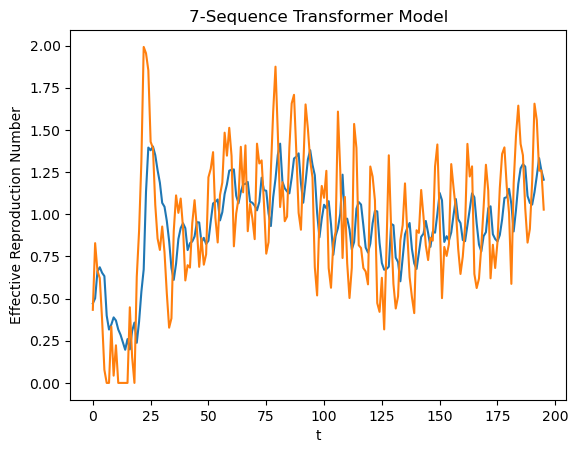

In [12]:
pred_7 = model_7.predict(x_test_7)
score = np.sqrt(metrics.mean_squared_error(pred_7,y_test_7))
print("Score (RMSE): {}".format(score))

plt.figure()
plt.plot(range(len(pred_7)),pred_7)
plt.plot(range(len(y_test_7)),y_test_7)
plt.title('7-Sequence Transformer Model')
plt.ylabel('Effective Reproduction Number')
plt.xlabel('t')
plt.show()

In [13]:
sub_df_7 = df.loc[df.index >= df.index[TRAIN_SPLIT + 7],['reproduction_number']]

sub_df_7.loc[sub_df_7.index >= df.index[TRAIN_SPLIT + 7],'reproduction_number'] = [pred_7[i][0] for i in range(len(pred_7))]
sub_df_7['prediction'] = 0
sub_df_7['actual'] = df.loc[df.index >= df.index[TRAIN_SPLIT + 7],'cases_new']
sub_df_7['error'] = 0

sub_df_7.head(10)

,reproduction_number,prediction,actual,error
date,,,,
2022-04-19,0.471152,0,6069,0
2022-04-20,0.501577,0,6968,0
2022-04-21,0.661541,0,5899,0
2022-04-22,0.685628,0,6342,0
2022-04-23,0.652927,0,5624,0
2022-04-24,0.632933,0,4006,0
2022-04-25,0.398964,0,2478,0
2022-04-26,0.316459,0,3361,0
2022-04-27,0.345736,0,3471,0


In [14]:
for idx in sub_df_7.index:
    rep_num = sub_df_7.loc[idx,'reproduction_number']
    sub_df_7.loc[idx,'prediction'] = SIR(df.loc[idx - dt.timedelta(1)],idx - dt.timedelta(1),rep_num)[1]
    sub_df_7.loc[idx,'error'] = sub_df_7.loc[idx,'prediction'] - sub_df_7.loc[idx,'actual']

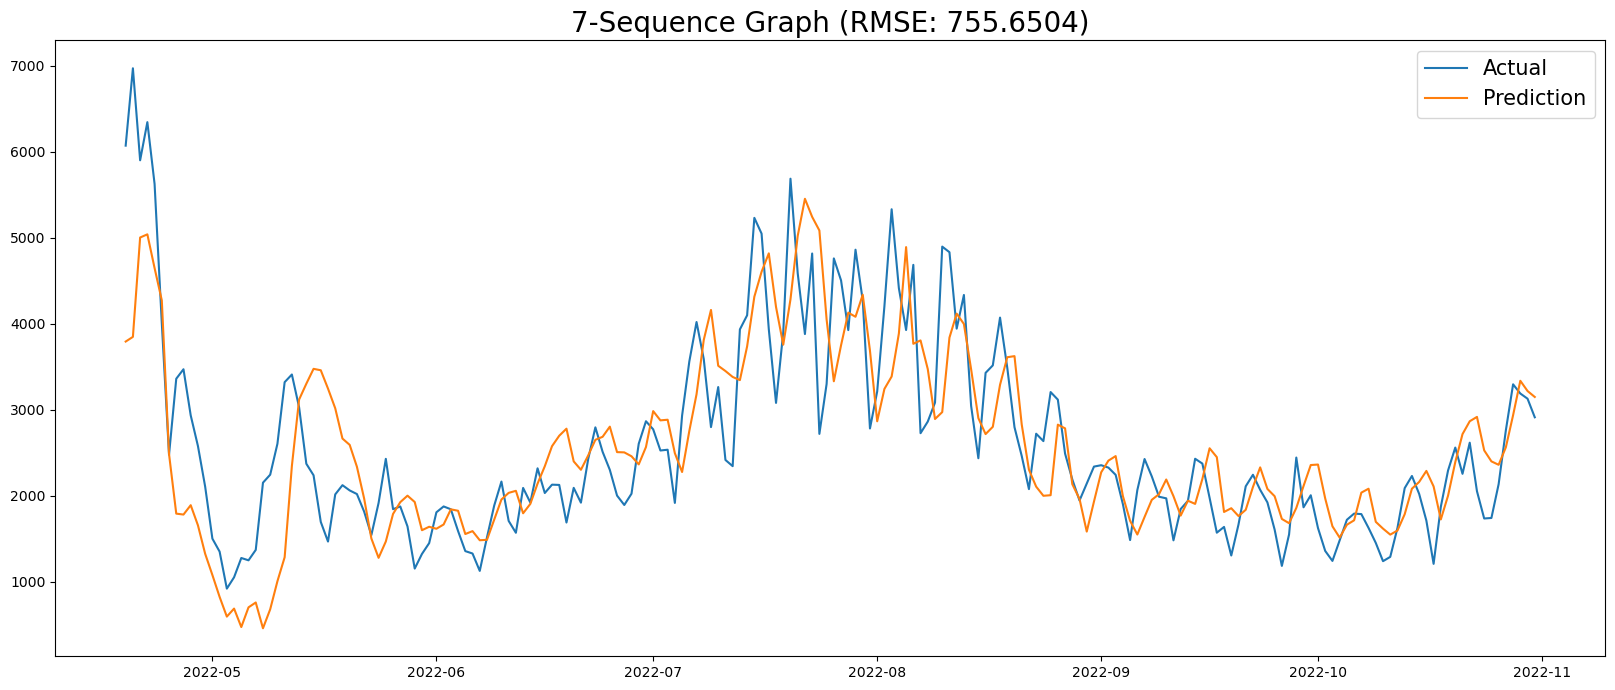

In [15]:
error_7 = np.sqrt((sub_df_7['error'] ** 2).mean())

plt.figure(figsize=(20,8))
plt.plot(df.loc[df.index >= df.index[TRAIN_SPLIT + 7],'cases_new'])
plt.plot(sub_df_7['prediction'])
plt.title(f'7-Sequence Graph (RMSE: {np.round(error_7,4)})',fontsize=20)
plt.legend(['Actual','Prediction'],fontsize=15)
plt.show()

In [16]:
model_7.save('Covid19-TRANSFORMER12-7.h5')

Model Sequence Length 10

In [17]:
tf.random.set_seed(1)
np.random.seed(1)

x_train_10,y_train_10 = set_sequence(10,train)
x_test_10,y_test_10 = set_sequence(10,test)

input_shape = x_train_10.shape[1:]

model_10 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_10.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model_10.fit(
    x_train_10,
    y_train_10,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model_10.evaluate(x_test_10, y_test_10, verbose=1)

Epoch 1/200
10/10 [==============================] - 10s 341ms/step - loss: 7.9239 - val_loss: 2.1942
Epoch 2/200
10/10 [==============================] - 3s 256ms/step - loss: 6.4288 - val_loss: 1.8803
Epoch 3/200
10/10 [==============================] - 2s 229ms/step - loss: 6.1546 - val_loss: 1.6653
Epoch 4/200
10/10 [==============================] - 2s 224ms/step - loss: 5.6555 - val_loss: 1.5099
Epoch 5/200
10/10 [==============================] - 2s 258ms/step - loss: 4.9063 - val_loss: 1.4092
Epoch 6/200
10/10 [==============================] - 3s 275ms/step - loss: 5.1211 - val_loss: 1.3360
Epoch 7/200
10/10 [==============================] - 2s 184ms/step - loss: 4.8952 - val_loss: 1.2691
Epoch 8/200
10/10 [==============================] - 2s 219ms/step - loss: 5.0243 - val_loss: 1.1926
Epoch 9/200
10/10 [==============================] - 2s 177ms/step - loss: 4.4270 - val_loss: 1.1111
Epoch 10/200
10/10 [==============================] - 3s 261ms/step - loss: 4.1031 - val_l

10/10 [==============================] - 2s 242ms/step - loss: 1.8814 - val_loss: 0.0722
Epoch 82/200
10/10 [==============================] - 3s 280ms/step - loss: 2.0748 - val_loss: 0.0726
Epoch 83/200
10/10 [==============================] - 3s 267ms/step - loss: 2.0087 - val_loss: 0.0723
Epoch 84/200
10/10 [==============================] - 3s 244ms/step - loss: 2.2001 - val_loss: 0.0732
Epoch 85/200
10/10 [==============================] - 3s 271ms/step - loss: 1.9223 - val_loss: 0.0728
Epoch 86/200
10/10 [==============================] - 3s 256ms/step - loss: 1.7252 - val_loss: 0.0719
Epoch 87/200
10/10 [==============================] - 3s 276ms/step - loss: 2.0544 - val_loss: 0.0720
Epoch 88/200
10/10 [==============================] - 3s 263ms/step - loss: 2.0892 - val_loss: 0.0719
Epoch 89/200
10/10 [==============================] - 3s 283ms/step - loss: 2.0128 - val_loss: 0.0714
Epoch 90/200
10/10 [==============================] - 3s 283ms/step - loss: 1.9601 - val_loss: 

0.15466898679733276

7/7 [==============================] - 1s 16ms/step
Score (RMSE): 0.3932797833994107


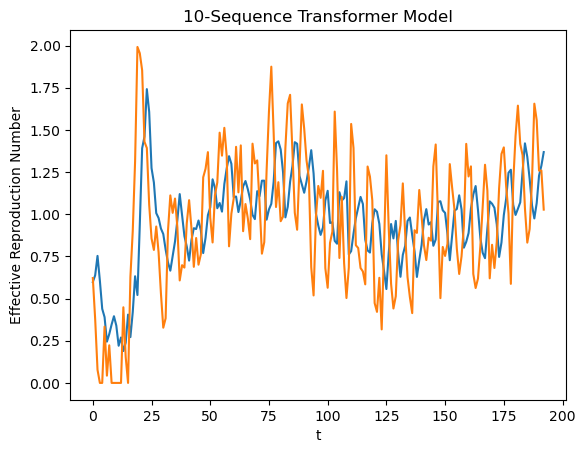

In [18]:
pred_10 = model_10.predict(x_test_10)
score = np.sqrt(metrics.mean_squared_error(pred_10,y_test_10))
print("Score (RMSE): {}".format(score))

plt.figure()
plt.plot(range(len(pred_10)),pred_10)
plt.plot(range(len(y_test_10)),y_test_10)
plt.title('10-Sequence Transformer Model')
plt.ylabel('Effective Reproduction Number')
plt.xlabel('t')
plt.show()

In [19]:
sub_df_10 = df.loc[df.index >= df.index[TRAIN_SPLIT + 10],['reproduction_number']]

sub_df_10.loc[sub_df_10.index >= df.index[TRAIN_SPLIT + 10],'reproduction_number'] = [pred_10[i][0] for i in range(len(pred_10))]
sub_df_10['prediction'] = 0
sub_df_10['actual'] = df.loc[df.index >= df.index[TRAIN_SPLIT + 10],'cases_new']
sub_df_10['error'] = 0

sub_df_10.head(10)

,reproduction_number,prediction,actual,error
date,,,,
2022-04-22,0.598033,0,6342,0
2022-04-23,0.638180,0,5624,0
2022-04-24,0.752990,0,4006,0
2022-04-25,0.606319,0,2478,0
2022-04-26,0.439149,0,3361,0
2022-04-27,0.390010,0,3471,0
2022-04-28,0.244531,0,2935,0
2022-04-29,0.289583,0,2579,0
2022-04-30,0.346311,0,2107,0


In [20]:
for idx in sub_df_10.index:
    rep_num = sub_df_10.loc[idx,'reproduction_number']
    sub_df_10.loc[idx,'prediction'] = SIR(df.loc[idx - dt.timedelta(1)],idx - dt.timedelta(1),rep_num)[1]
    sub_df_10.loc[idx,'error'] = sub_df_10.loc[idx,'prediction'] - sub_df_10.loc[idx,'actual']

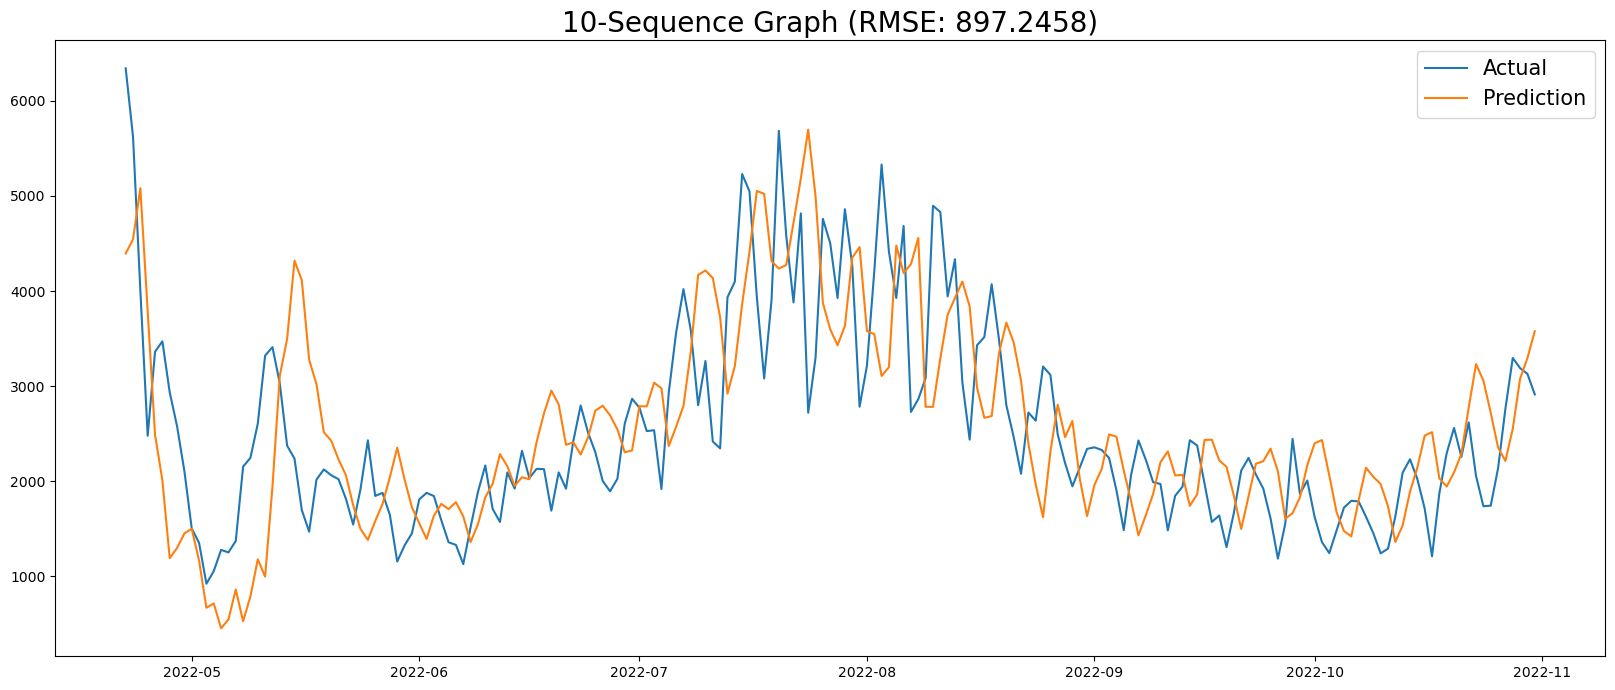

In [21]:
error_10 = np.sqrt((sub_df_10['error'] ** 2).mean())

plt.figure(figsize=(20,8))
plt.plot(df.loc[df.index >= df.index[TRAIN_SPLIT + 10],'cases_new'])
plt.plot(sub_df_10['prediction'])
plt.title(f'10-Sequence Graph (RMSE: {np.round(error_10,4)})',fontsize=20)
plt.legend(['Actual','Prediction'],fontsize=15)
plt.show()

Model Sequence Length 15

In [22]:
tf.random.set_seed(1)
np.random.seed(1)

x_train_15,y_train_15 = set_sequence(15,train)
x_test_15,y_test_15 = set_sequence(15,test)

input_shape = x_train_15.shape[1:]

model_15 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_15.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model_15.fit(
    x_train_15,
    y_train_15,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model_15.evaluate(x_test_15, y_test_15, verbose=1)

Epoch 1/200
10/10 [==============================] - 10s 396ms/step - loss: 9.2942 - val_loss: 2.8620
Epoch 2/200
10/10 [==============================] - 3s 265ms/step - loss: 7.2907 - val_loss: 2.3057
Epoch 3/200
10/10 [==============================] - 2s 242ms/step - loss: 7.5047 - val_loss: 1.9145
Epoch 4/200
10/10 [==============================] - 3s 268ms/step - loss: 6.4069 - val_loss: 1.6588
Epoch 5/200
10/10 [==============================] - 3s 242ms/step - loss: 5.4382 - val_loss: 1.5042
Epoch 6/200
10/10 [==============================] - 3s 303ms/step - loss: 5.1331 - val_loss: 1.4114
Epoch 7/200
10/10 [==============================] - 3s 301ms/step - loss: 4.8086 - val_loss: 1.3400
Epoch 8/200
10/10 [==============================] - 3s 312ms/step - loss: 5.3183 - val_loss: 1.2628
Epoch 9/200
10/10 [==============================] - 3s 298ms/step - loss: 5.0369 - val_loss: 1.1820
Epoch 10/200
10/10 [==============================] - 3s 270ms/step - loss: 5.1869 - val_l

10/10 [==============================] - 3s 287ms/step - loss: 2.1055 - val_loss: 0.0772
Epoch 82/200
10/10 [==============================] - 2s 223ms/step - loss: 1.8740 - val_loss: 0.0764
Epoch 83/200
10/10 [==============================] - 3s 257ms/step - loss: 1.9635 - val_loss: 0.0756
Epoch 84/200
10/10 [==============================] - 3s 260ms/step - loss: 2.1017 - val_loss: 0.0754
Epoch 85/200
10/10 [==============================] - 3s 286ms/step - loss: 2.0981 - val_loss: 0.0752
Epoch 86/200
10/10 [==============================] - 3s 319ms/step - loss: 2.0403 - val_loss: 0.0751
Epoch 87/200
10/10 [==============================] - 3s 315ms/step - loss: 1.9097 - val_loss: 0.0751
Epoch 88/200
10/10 [==============================] - 3s 275ms/step - loss: 2.1113 - val_loss: 0.0757
Epoch 89/200
10/10 [==============================] - 2s 239ms/step - loss: 1.9907 - val_loss: 0.0755
Epoch 90/200
10/10 [==============================] - 3s 271ms/step - loss: 2.0181 - val_loss: 

0.15189041197299957

6/6 [==============================] - 1s 19ms/step
Score (RMSE): 0.3897311928940163


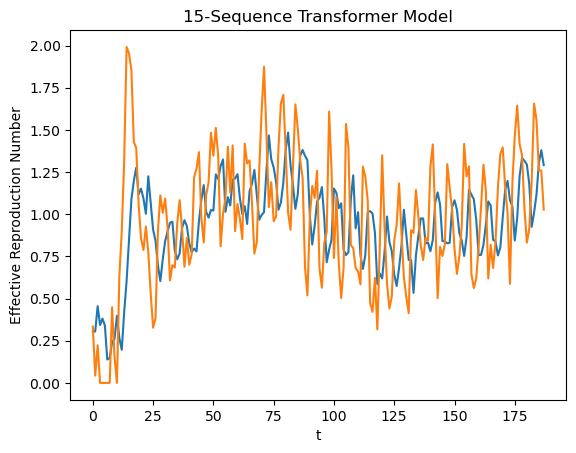

In [23]:
pred_15 = model_15.predict(x_test_15)
score = np.sqrt(metrics.mean_squared_error(pred_15,y_test_15))
print("Score (RMSE): {}".format(score))

plt.figure()
plt.plot(range(len(pred_15)),pred_15)
plt.plot(range(len(y_test_15)),y_test_15)
plt.title('15-Sequence Transformer Model')
plt.ylabel('Effective Reproduction Number')
plt.xlabel('t')
plt.show()

In [24]:
sub_df_15 = df.loc[df.index >= df.index[TRAIN_SPLIT + 15],['reproduction_number']]

sub_df_15.loc[sub_df_15.index >= df.index[TRAIN_SPLIT + 15],'reproduction_number'] = [pred_15[i][0] for i in range(len(pred_15))]
sub_df_15['prediction'] = 0
sub_df_15['actual'] = df.loc[df.index >= df.index[TRAIN_SPLIT + 15],'cases_new']
sub_df_15['error'] = 0

sub_df_15.head(10)

,reproduction_number,prediction,actual,error
date,,,,
2022-04-27,0.303593,0,3471,0
2022-04-28,0.305125,0,2935,0
2022-04-29,0.455037,0,2579,0
2022-04-30,0.343267,0,2107,0
2022-05-01,0.381431,0,1503,0
2022-05-02,0.340318,0,1352,0
2022-05-03,0.138858,0,922,0
2022-05-04,0.147417,0,1054,0
2022-05-05,0.243151,0,1278,0


In [25]:
for idx in sub_df_15.index:
    rep_num = sub_df_15.loc[idx,'reproduction_number']
    sub_df_15.loc[idx,'prediction'] = SIR(df.loc[idx - dt.timedelta(1)],idx,rep_num)[1]
    sub_df_15.loc[idx,'error'] = sub_df_15.loc[idx,'prediction'] - sub_df_15.loc[idx,'actual']

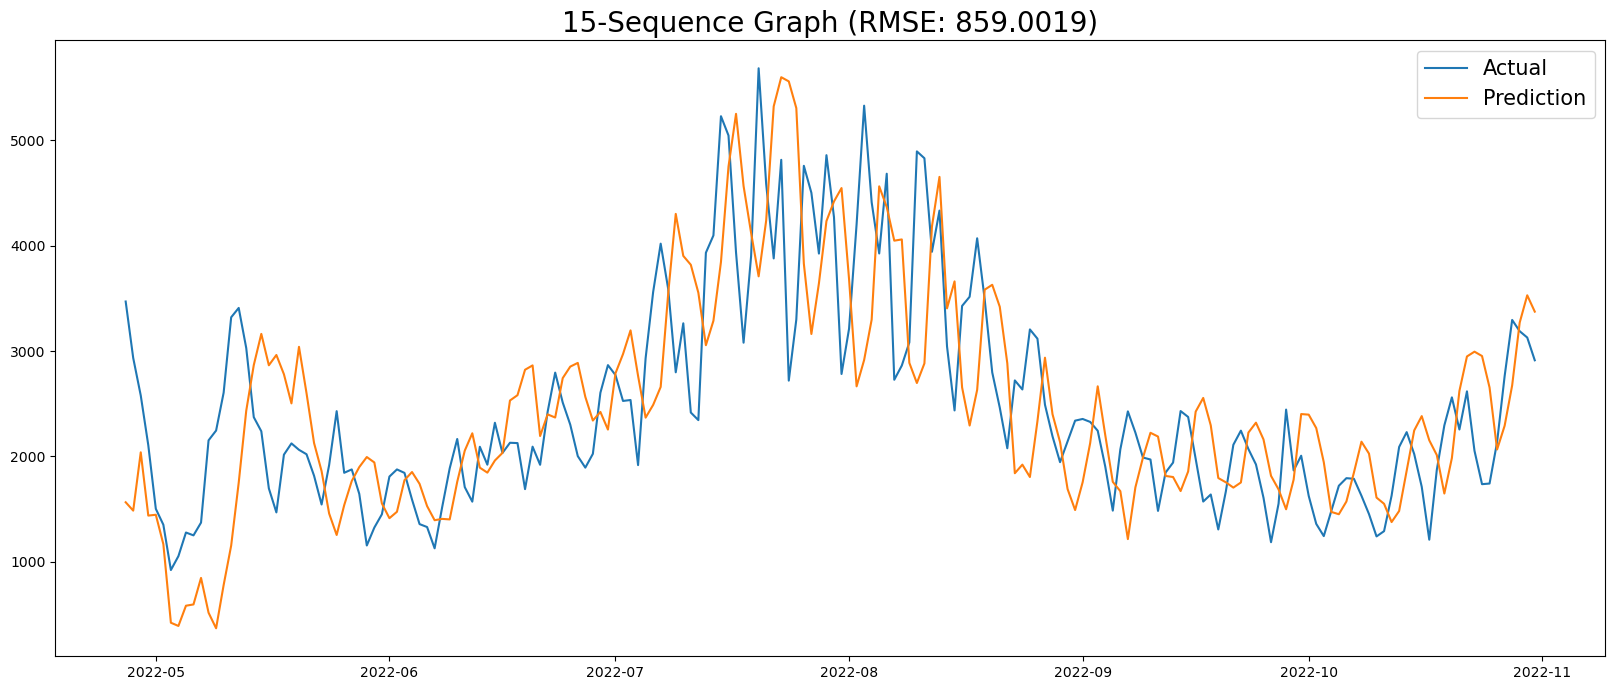

In [26]:
error_15 = np.sqrt((sub_df_15['error'] ** 2).mean())

plt.figure(figsize=(20,8))
plt.plot(df.loc[df.index >= df.index[TRAIN_SPLIT + 15],'cases_new'])
plt.plot(sub_df_15['prediction'])
plt.title(f'15-Sequence Graph (RMSE: {np.round(error_15,4)})',fontsize=20)
plt.legend(['Actual','Prediction'],fontsize=15)
plt.show()

Model Sequence Length 20

In [27]:
tf.random.set_seed(1)
np.random.seed(1)

x_train_20,y_train_20 = set_sequence(20,train)
x_test_20,y_test_20 = set_sequence(20,test)

input_shape = x_train_20.shape[1:]

model_20 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_20.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model_20.fit(
    x_train_20,
    y_train_20,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model_20.evaluate(x_test_20, y_test_20, verbose=1)

Epoch 1/200
10/10 [==============================] - 8s 357ms/step - loss: 11.4120 - val_loss: 3.5249
Epoch 2/200
10/10 [==============================] - 3s 265ms/step - loss: 9.7173 - val_loss: 2.7146
Epoch 3/200
10/10 [==============================] - 2s 212ms/step - loss: 8.5485 - val_loss: 2.1673
Epoch 4/200
10/10 [==============================] - 2s 241ms/step - loss: 7.0656 - val_loss: 1.8243
Epoch 5/200
10/10 [==============================] - 3s 261ms/step - loss: 7.5955 - val_loss: 1.6201
Epoch 6/200
10/10 [==============================] - 3s 294ms/step - loss: 6.4155 - val_loss: 1.4941
Epoch 7/200
10/10 [==============================] - 2s 248ms/step - loss: 5.8662 - val_loss: 1.3971
Epoch 8/200
10/10 [==============================] - 3s 245ms/step - loss: 6.0525 - val_loss: 1.3115
Epoch 9/200
10/10 [==============================] - 2s 265ms/step - loss: 5.4698 - val_loss: 1.2243
Epoch 10/200
10/10 [==============================] - 3s 313ms/step - loss: 5.2535 - val_l

10/10 [==============================] - 3s 252ms/step - loss: 2.3783 - val_loss: 0.0747
Epoch 82/200
10/10 [==============================] - 3s 269ms/step - loss: 2.4021 - val_loss: 0.0745
Epoch 83/200
10/10 [==============================] - 3s 251ms/step - loss: 2.1784 - val_loss: 0.0746
Epoch 84/200
10/10 [==============================] - 2s 247ms/step - loss: 2.4572 - val_loss: 0.0741
Epoch 85/200
10/10 [==============================] - 3s 263ms/step - loss: 2.4960 - val_loss: 0.0748
Epoch 86/200
10/10 [==============================] - 3s 283ms/step - loss: 2.2380 - val_loss: 0.0788
Epoch 87/200
10/10 [==============================] - 3s 258ms/step - loss: 2.0822 - val_loss: 0.0756
Epoch 88/200
10/10 [==============================] - 2s 243ms/step - loss: 1.9874 - val_loss: 0.0740
Epoch 89/200
10/10 [==============================] - 2s 228ms/step - loss: 2.2586 - val_loss: 0.0718
Epoch 90/200
10/10 [==============================] - 2s 161ms/step - loss: 2.5048 - val_loss: 

0.10083723068237305

6/6 [==============================] - 1s 29ms/step
Score (RMSE): 0.31754879043098383


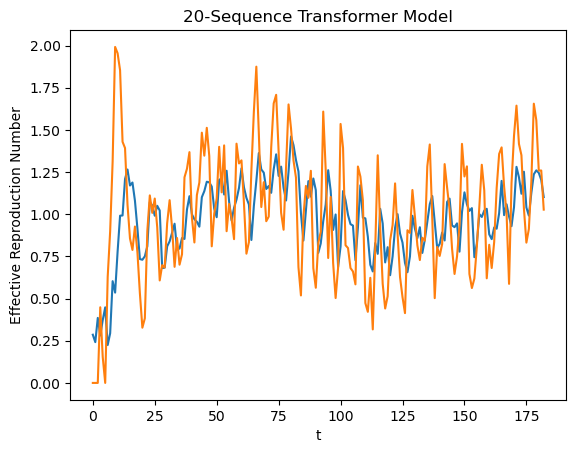

In [28]:
pred_20 = model_20.predict(x_test_20)
score = np.sqrt(metrics.mean_squared_error(pred_20,y_test_20))
print("Score (RMSE): {}".format(score))

plt.figure()
plt.plot(range(len(pred_20)),pred_20)
plt.plot(range(len(y_test_20)),y_test_20)
plt.title('20-Sequence Transformer Model')
plt.ylabel('Effective Reproduction Number')
plt.xlabel('t')
plt.show()

In [29]:
sub_df_20 = df.loc[df.index >= df.index[TRAIN_SPLIT + 20],['reproduction_number']]

sub_df_20.loc[sub_df_20.index >= df.index[TRAIN_SPLIT + 20],'reproduction_number'] = [pred_20[i][0] for i in range(len(pred_20))]
sub_df_20['prediction'] = 0
sub_df_20['actual'] = df.loc[df.index >= df.index[TRAIN_SPLIT + 20],'cases_new']
sub_df_20['error'] = 0

sub_df_20.head(10)

,reproduction_number,prediction,actual,error
date,,,,
2022-05-02,0.285779,0,1352,0
2022-05-03,0.241659,0,922,0
2022-05-04,0.385333,0,1054,0
2022-05-05,0.281244,0,1278,0
2022-05-06,0.372416,0,1251,0
2022-05-07,0.447943,0,1372,0
2022-05-08,0.224768,0,2153,0
2022-05-09,0.294418,0,2246,0
2022-05-10,0.603146,0,2605,0


In [30]:
for idx in sub_df_20.index:
    rep_num = sub_df_20.loc[idx,'reproduction_number']
    sub_df_20.loc[idx,'prediction'] = SIR(df.loc[idx - dt.timedelta(1)],idx,rep_num)[1]
    sub_df_20.loc[idx,'error'] = sub_df_20.loc[idx,'prediction'] - sub_df_20.loc[idx,'actual']

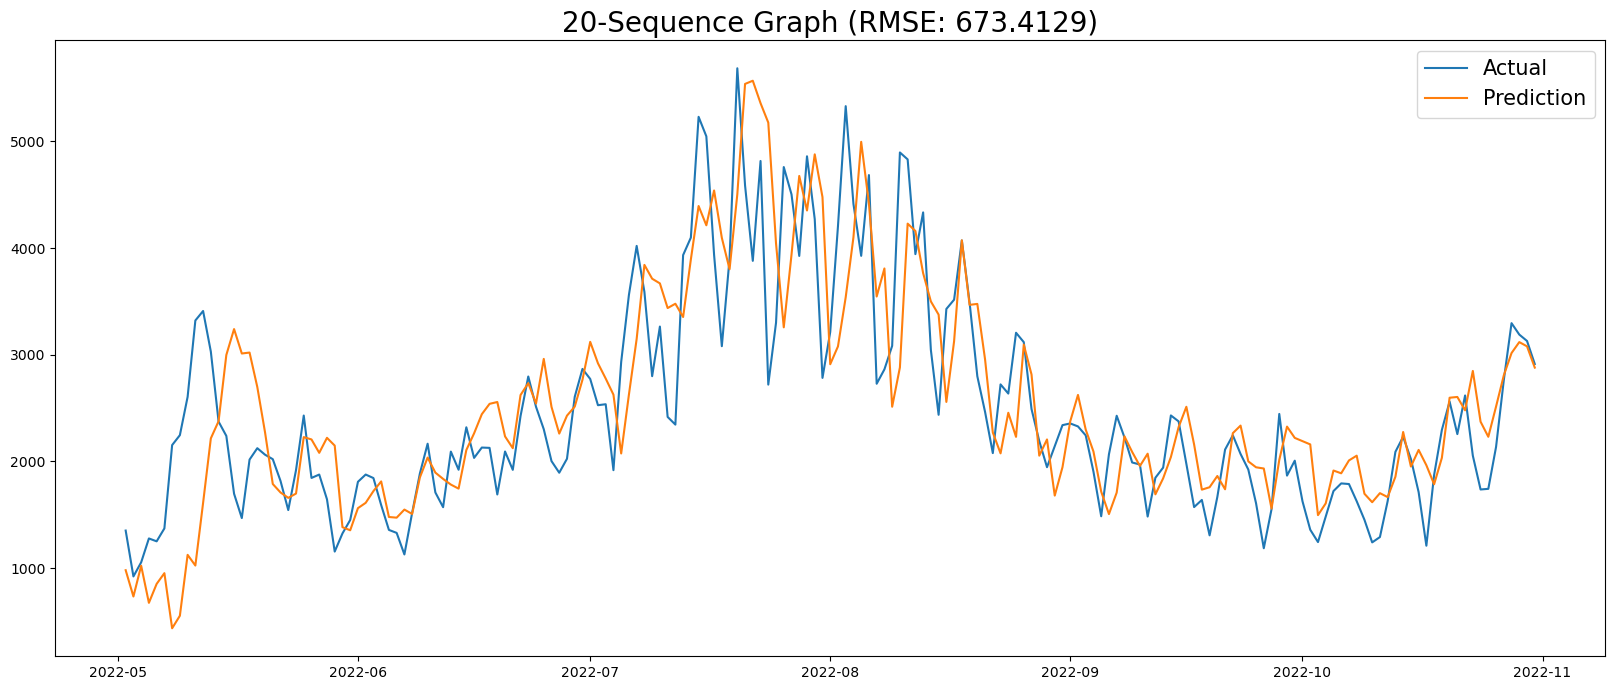

In [31]:
error_20 = np.sqrt((sub_df_20['error'] ** 2).mean())

plt.figure(figsize=(20,8))
plt.plot(df.loc[df.index >= df.index[TRAIN_SPLIT + 20],'cases_new'])
plt.plot(sub_df_20['prediction'])
plt.title(f'20-Sequence Graph (RMSE: {np.round(error_20,4)})',fontsize=20)
plt.legend(['Actual','Prediction'],fontsize=15)
plt.show()

In [32]:
x_test_7[0]

array([[0.28484208],
       [0.44363697],
       [0.72068262],
       [0.53033866],
       [0.50664888],
       [0.48892411],
       [0.15701334]])

In [33]:
from keras.models import load_model

model = load_model('Covid19-TRANSFORMER12-7.h5')

In [34]:
def get_full_data():
    df = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv',
                          parse_dates = ['date'],index_col = ['date'])
    
    new_df = df.loc[:,['cases_new','cases_active']]
    
    new_df['cases_recovered'] = (new_df['cases_active'].shift() + new_df['cases_new']) - new_df['cases_active']
    new_df['cases_recovered_C'] = new_df['cases_recovered'].cumsum()
    new_df['susceptible'] = population - new_df['cases_active'] - new_df['cases_recovered_C']
    growth_rate = (new_df['cases_active'] - new_df['cases_active'].shift()) / new_df['cases_active'].shift()
    new_df['reproduction_number'] = np.maximum(0,1 + (growth_rate / gamma))
    #a = new_df['reproduction_number'] - 1
    #new_df['cases_active_calc'] = new_df['cases_active'].shift() + (gamma * a * new_df['cases_active'].shift())
    new_df.to_csv('malaysia-covid-cases.csv')
    
    return new_df

In [35]:
s = get_full_data().loc[df.index[1]:,'reproduction_number']

for i in range(365):
    s_seq,_ = set_sequence(7,s)
    seq_s = np.array([s_seq[len(s_seq) - 1]])
    t = model.predict(seq_s)[0][0]
    s.loc[s.index[len(s.index) - 1] + dt.timedelta(1)] = t
    print(t)

1/1 [==============================] - 1s 654ms/step
0.8651082
1/1 [==============================] - 0s 25ms/step
0.9235659
1/1 [==============================] - 0s 22ms/step
0.9843216
1/1 [==============================] - 0s 24ms/step
0.91041327
1/1 [==============================] - 0s 21ms/step
0.9702067
1/1 [==============================] - 0s 28ms/step
0.9511719
1/1 [==============================] - 0s 26ms/step
0.9507332
1/1 [==============================] - 0s 29ms/step
0.99099654
1/1 [==============================] - 0s 24ms/step
0.96518993
1/1 [==============================] - 0s 37ms/step
0.9802644
1/1 [==============================] - 0s 23ms/step
0.99039716
1/1 [==============================] - 0s 21ms/step
0.98280257
1/1 [==============================] - 0s 21ms/step
0.9957823
1/1 [==============================] - 0s 20ms/step
0.99674964
1/1 [==============================] - 0s 20ms/step
0.9988964
1/1 [==============================] - 0s 21ms/step
1.0070921
1

1/1 [==============================] - 0s 21ms/step
1.0757431
1/1 [==============================] - 0s 25ms/step
1.0757508
1/1 [==============================] - 0s 23ms/step
1.0757577
1/1 [==============================] - 0s 21ms/step
1.0757649
1/1 [==============================] - 0s 21ms/step
1.0757715
1/1 [==============================] - 0s 22ms/step
1.0757779
1/1 [==============================] - 0s 20ms/step
1.0757836
1/1 [==============================] - 0s 22ms/step
1.0757892
1/1 [==============================] - 0s 20ms/step
1.0757946
1/1 [==============================] - 0s 20ms/step
1.0757997
1/1 [==============================] - 0s 21ms/step
1.0758041
1/1 [==============================] - 0s 21ms/step
1.0758089
1/1 [==============================] - 0s 25ms/step
1.0758132
1/1 [==============================] - 0s 24ms/step
1.0758172
1/1 [==============================] - 0s 23ms/step
1.075821
1/1 [==============================] - 0s 20ms/step
1.075825
1/1 [=====

1/1 [==============================] - 0s 24ms/step
1.0758915
1/1 [==============================] - 0s 24ms/step
1.0758915
1/1 [==============================] - 0s 33ms/step
1.0758915
1/1 [==============================] - 0s 28ms/step
1.0758915
1/1 [==============================] - 0s 26ms/step
1.0758914
1/1 [==============================] - 0s 25ms/step
1.0758915
1/1 [==============================] - 0s 23ms/step
1.0758915
1/1 [==============================] - 0s 21ms/step
1.0758915
1/1 [==============================] - 0s 23ms/step
1.0758915
1/1 [==============================] - 0s 25ms/step
1.0758916
1/1 [==============================] - 0s 24ms/step
1.0758915
1/1 [==============================] - 0s 25ms/step
1.0758915
1/1 [==============================] - 0s 24ms/step
1.0758915
1/1 [==============================] - 0s 24ms/step
1.0758915
1/1 [==============================] - 0s 22ms/step
1.0758915
1/1 [==============================] - 0s 23ms/step
1.0758915
1/1 [===

In [36]:
s.loc[(s.index >= df.index[1000]) & (s.index < df.index[1007])].rolling(7).mean()[df.index[1006]]

1.1993059003132944

In [37]:
df.index[1006]

Timestamp('2022-10-27 00:00:00')

In [38]:
df[df['cases_new'] == df['cases_new'].max()].index

DatetimeIndex(['2022-03-05'], dtype='datetime64[ns]', name='date', freq=None)